# On the Suitability of RTT Measurements for Geolocation

rev. 0, 11 August 2017, [Brian Trammell](mailto: ietf@trammell.ch), Networked Systems Group, ETH Zürich

#### Abstract

It is widely understood in the network measurement community that round trip time measurements, whether passively derived by observation of transport-layer or application-layer signals linking packets in one direction to counterparts in another, or actively measured using a facility such as ICMP echo reply, are not on their own useful as input to trilateration for geolocation, as they are dominated by error terms which are not easy to remove. While detailing several attempts to correct for this error in order to use RTT measurements for certain geolocation tasks appear in the literature, there has not to date been an attempt to provide a quantitiative, empirical study of this error as guidance for applying RTT measurements for geolocation.

This work uses RTTs derived from RIPE Atlas Ping measurements to address this shortcoming. This dataset is especially useful in that we have presumptive ground truth for the locations o Atlas probes and a set of dedicated measurement targets, called Atlas anchors, which allows us to compare our RTT-derived estimated distances to actual distances, as well as to derive empirical models for a function deriving distance from observed RTT.

_Conclusions from the study go here_. 

#### About this notebook

This is a Jupyter notebook containing the analysis code used to generate its visualizations; it is, in a sense, a "runnable paper". It depends on the [dataprep](dataprep.ipynb) notebook in this directory to download measurements from RIPE Atlas and place them in distilled form in an HDF5 datastore, from which this paper reads data and generates visualizations and tables. If you don't have an HDF5 datastore locally, go run the [dataprep](dataprep.ipynb) notebook now, then come back here.

Run the following cell to set up the environment, import useful packages, and load the dataframes from which this paper's analysis and visualization will follow:

In [8]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math

from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings("ignore") 

with pd.HDFStore('rtt.h5') as store:
    anchor_df = store['anchor_df']
    probe_df = store['probe_df']
    rtt_df = store['rtt_df']
    
min_df = pd.DataFrame({'minrtt': rtt_df.groupby(['aid','pid'])['rtt'].min()})
loc_by_aid = anchor_df.loc[:,('lon','lat')]
loc_by_aid.columns = ['alon','alat']
loc_by_pid = probe_df.loc[:,('lon','lat')]
loc_by_pid.columns = ['plon','plat']
min_df = loc_by_pid.join(loc_by_aid.join(min_df, how="inner"), how="inner")

## Introduction

In this work, we seek to answer the question "how useful is Internet end-to-end round-trip-time (RTT; also known as two-way delay) measurement to the problem of locating an endpoint with unknown location, given known location for other endpoint(s) it communicates with?"; or in the more negative sense, "how much risk does exposure of one's end-to-end RTT pose to the geographical privacy of a given endpoint?". We examine this question in two ways: by attempting to use RTT data as input for geolocation by [trilateration](https://en.wikipedia.org/wiki/Trilateration), and by attempting to localize by exclusion.

For trilateration, we must find a function of RTT that yields a distance:

$$ dist = f(RTT) $$

We first note that observable RTT is given by the equation:

$$ RTT_{obs} = \sum_{n=0}^f(D_{prop_{n \rightarrow n+1}} + D_{queue_n} + D_{proc_n}) + \sum_{m=0}^r(D_{prop_{m \rightarrow m+1}} + D_{queue_m} + D_{proc_m}) + D_{app} $$

In other words, for _f_ hops in the forward direction and _r_ hops in the reverse direction, the observed RTT is the sum of propagation, queueing, and processing delay at each hop, plus any delay at the far endpoint (here labeled as application delay). The idealized RTT for geolocation purposes, however, would be:

$$ RTT_{ideal} = \sum_{n=0}^f D_{prop_{n \rightarrow n+1}} + \sum_{m=0}^r D_{prop_{m \rightarrow m+1}} $$

This ideal situation only holds in the unlikely circumstance that sources of error (i.e., variable queueing delay, unmeasurable processing delay, and application delay) are zero:

$$ RTT_{obs} = RTT_{ideal} \iff RTT_{error} = \sum_{n=0}^f(D_{queue_n} + D_{proc_n}) + \sum_{m=0}^r(D_{queue_m} + D_{proc_m}) + D_{app} = 0 $$

Even this impossible, idealized situation would not yield us a perfect $dist = f(RTT)$, as the propagation delays themselves follow the paths of the optical fiber, copper wire, radio or optical wireless link carrying each hop, which do not follow straight lines, and each of which may have its own functions determining distance given delay. Nevertheless we will first look at the distribution of $RTT_{obs}$ versus known distances using the [RIPE Atlas](https://atlas.ripe.net) measurement network, in order to determine whether an $f(RTT)$ suitable for trilateration can be derived.

Failing that, the only thing we can say with complete certainty is that distance given an estimated one-way delay cannot be equal to or greater than the speed of light:

$$ dist < \frac{RTT_{obs}}{2} \times c $$

We therefore then turn our attention to geolocation by exclusion: by taking RTT measurements from a set of vantage points with known locations, by determining the locations where an endpoint cannot be based on the inequality above for each vantage point, then taking the union of all those locations: the endpoint must therefore be somewhere within the area outside of those areas it cannot be.

We conclude that _conclusions go here_.

### Related Work

_a few words about related work, cite Cicalese et al on anycast location_


## Methodology and Results

We use RTT data taken from the [RIPE Atlas](https://atlas.ripe.net) measurement network, selecting a set of 32 anchors from the more than 200 deployed; the list of selected anchors is shown in [the dataprep notebook](dataprep.ipynb#Anchor-Selection). We then find  ping (ICMP echo request/reply) measurements targeted to each of these anchors. The set of anchors and probes used in these anchoring measurements is plotted on the map below:

In [ ]:
# Get locations of anchors and probes in the dataset
aloc_df = min_df.groupby(level=[0]).first().loc[:,['alon','alat']]
ploc_df = min_df.groupby(level=[1]).first().loc[:,['plon','plat']]

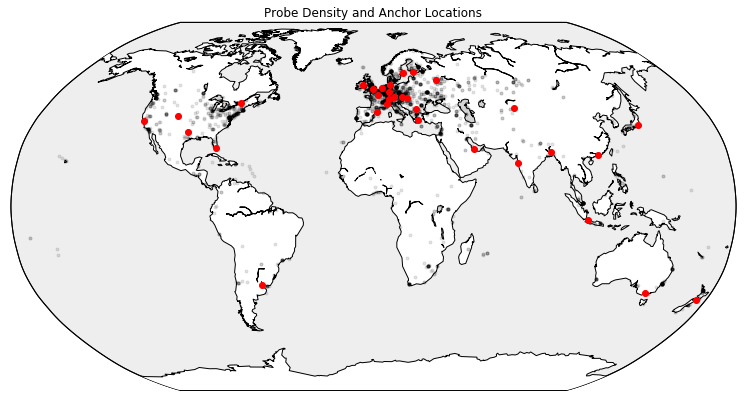

In [9]:
# Plot all anchors and probes on the world map
plt.figure(figsize=(13,10))
m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='white',lake_color='lightgrey')
m.drawmapboundary(fill_color='#eeeeee')
plt.title("Probe Density and Anchor Locations")
for pid, point in ploc_df.iterrows():
    x, y = m(point['plon'], point['plat'])
    plt.plot(x,y,"k.",alpha=0.2)
for aid, point in aloc_df.iterrows():
    x, y = m(point['alon'], point['alat'])
    plt.plot(x,y,"ro")
plt.show()

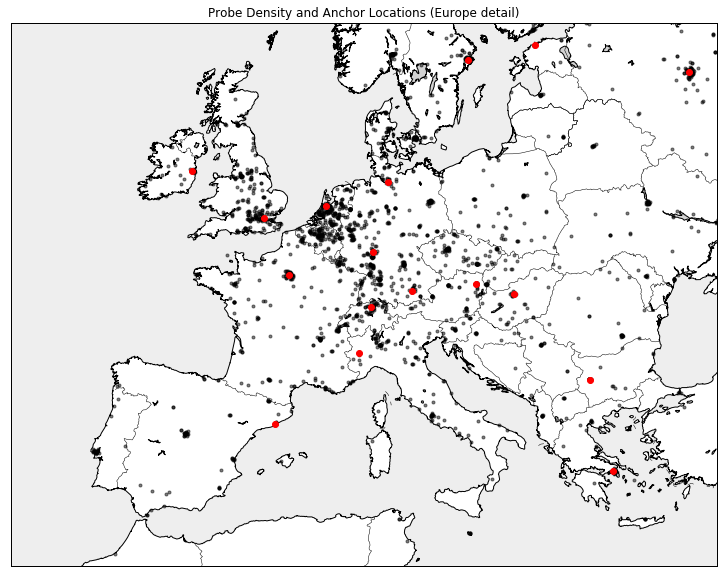

In [10]:
plt.figure(figsize=(13,10))
m = Basemap(width=3900000, height=3000000, projection='laea',lat_0=48,lon_0=8,resolution='i')
m.drawcoastlines()
m.fillcontinents(color='white',lake_color='lightgrey')
m.drawcountries()
m.drawmapboundary(fill_color='#eeeeee')
plt.title("Probe Density and Anchor Locations (Europe detail)")
for pid, point in ploc_df.iterrows():
    x, y = m(point['plon'], point['plat'])
    plt.plot(x,y,"k.",alpha=0.5)
for aid, point in aloc_df.iterrows():
    x, y = m(point['alon'], point['alat'])
    plt.plot(x,y,"ro")
plt.show()

In [1]:
## TODO